In [6]:
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.distributions import MultivariateNormal
import gpytorch 
import torch 
from tqdm import tqdm
import numpy as np  
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.base_covar_module = ScaleKernel(RBFKernel())

        num_samples = 5
        indices = torch.randperm(len(train_x))[:num_samples]
        inducing_points = train_x[indices].clone()
        self.covar_module = InducingPointKernel(self.base_covar_module, inducing_points=inducing_points, likelihood=likelihood)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [7]:
import numpy as np
amplitude=1
frequency=1
noise=0.3
number_of_cycles=1
omega= 2*np.pi*frequency
number_samples=500000
time=np.linspace(0, number_of_cycles/frequency,number_samples)

y=amplitude * np.sin(omega*time) 
y_noise= y+ np.random.normal(0, noise, number_samples)
# prepare inputs for gp
X=time.reshape(-1,1)
Y=y_noise.reshape(-1,)
t_test=np.linspace(- 0.5* number_of_cycles/frequency, 1.5* number_of_cycles/frequency, 300).reshape(-1,1)

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)
t_test = torch.tensor(t_test, dtype=torch.float32)

In [8]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(X, Y, likelihood)

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()
    X = X.cuda()
    Y = Y.cuda()
    t_test = t_test.cuda()

In [9]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 5000
iterator = tqdm(range(training_iterations), desc="Train")

for i in iterator:
    # Zero backprop gradients
    optimizer.zero_grad()
    # Get output from model
    output = model(X)
    # Calc loss and backprop derivatives
    loss = -mll(output, Y)
    loss.backward()
    iterator.set_postfix(loss=loss.item())
    optimizer.step()
    torch.cuda.empty_cache()

Train: 100%|██████████| 5000/5000 [00:43<00:00, 114.92it/s, loss=0.19]


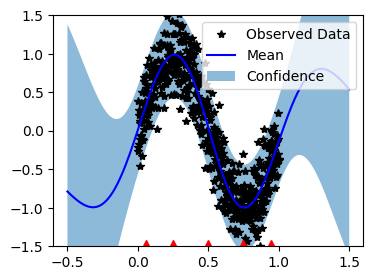

In [10]:
model.eval()
likelihood.eval()
with torch.no_grad():
    preds = model.likelihood(model(t_test.cuda()))

import matplotlib.pyplot as plt
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.plot(X.cpu().numpy(), Y.cpu().numpy(), 'k*')
    ax.plot(t_test.cpu().numpy(), preds.mean.cpu().numpy(), 'b')
    ax.fill_between(t_test.cpu().numpy().reshape(-1,), preds.mean.cpu().numpy() - 1.96 * preds.variance.sqrt().cpu().numpy(),
                    preds.mean.cpu().numpy() + 1.96 * preds.variance.sqrt().cpu().numpy(), alpha=0.5)
    ax.plot(model.covar_module.inducing_points.cpu(), -1.5* torch.ones(model.covar_module.inducing_points.shape[0]).cpu(), "r^", markersize=8)
    ax.set_ylim(-1.5, 1.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.show()